# Using and setting up easyfsl

In [1]:
!pip install easyfsl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from pathlib import Path
import random
from statistics import mean

import numpy as np
import torch
from torch import nn
from tqdm import tqdm

## Setting seed

In [3]:
random_seed = 0
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Loading Dataset

In [4]:
from torch.utils.data import DataLoader
from torchvision.datasets import Flowers102
from torchvision import transforms

batch_size = 16
n_workers = 2
image_size = 128
train_set = Flowers102(
    root="./data",
    split = 'train',
    transform=transforms.Compose(
        [
            transforms.Resize((image_size,image_size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
        ]
    ),
    download=True,
)
train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    num_workers=n_workers,
    pin_memory=True,
    shuffle=True,
)

In [5]:
print(f'Length of train dataset: {len(train_set)}')

Length of train dataset: 1020


# Classical training

## Transfer learning with resnet12

In [6]:
train_set.get_labels = lambda: [
    instance[1] for instance in train_set
]

In [7]:
print(f"Num of flower classes: {len(set(train_set.get_labels()))}")

Num of flower classes: 102


In [8]:
from easyfsl.modules import resnet18

DEVICE = "cuda"

model = resnet18(
    use_fc=True,
    num_classes=102,
).to(DEVICE)

## Task sampling

In [9]:
from easyfsl.methods import PrototypicalNetworks
from easyfsl.samplers import TaskSampler
n_way = 5
n_shot = 4
n_query = 6
n_validation_tasks = 100

val_set = Flowers102(
    root="./data",
    split = 'val',
    transform=transforms.Compose(
        [
            transforms.Resize((image_size,image_size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
        ]
    ),
    download=True,
)

In [10]:

val_set.get_labels = lambda: [
    instance[1] for instance in val_set
]
val_sampler = TaskSampler(
    val_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_validation_tasks
)

val_loader = DataLoader(
    val_set,
    batch_sampler=val_sampler,
    num_workers=2,
    pin_memory=True,
    collate_fn=val_sampler.episodic_collate_fn,
)

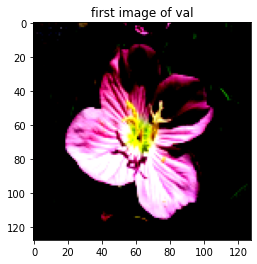

In [11]:
from easyfsl.utils import plot_images
plot_images(val_set[0][0], "first image of val", 1)

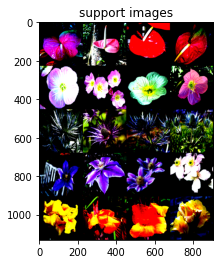

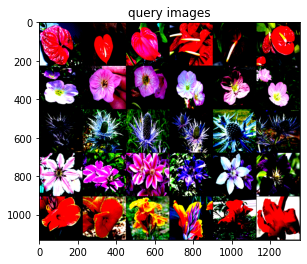

In [ ]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids
) = next(iter(val_loader))
plot_images(example_support_images, "support images", images_per_row=n_shot)
plot_images(example_query_images, "query images", images_per_row=n_query)

In [ ]:
few_shot_classifier = PrototypicalNetworks(model).to(DEVICE)

## Training for 20 epochs

In [ ]:
from torch.optim import SGD, Optimizer, Adam
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter


LOSS_FUNCTION = nn.CrossEntropyLoss()

n_epochs = 8
scheduler_milestones = [150, 180]
scheduler_gamma = 0.1
learning_rate = 1e-02
tb_logs_dir = Path(".")

train_optimizer = SGD(
    model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4
)
#train_optimizer = Adam()

train_scheduler = MultiStepLR(
    train_optimizer,
    milestones=scheduler_milestones,
    gamma=scheduler_gamma,
)

tb_writer = SummaryWriter(log_dir=str(tb_logs_dir))

In [ ]:
def training_epoch(model_: nn.Module, data_loader: DataLoader, optimizer: Optimizer):
    all_loss = []
    model_.train()
    with tqdm(data_loader, total=len(data_loader), desc="Training") as tqdm_train:
        for images, labels in tqdm_train:
            optimizer.zero_grad()

            loss = LOSS_FUNCTION(model_(images.to(DEVICE)), labels.to(DEVICE))
            loss.backward()
            optimizer.step()

            all_loss.append(loss.item())

            tqdm_train.set_postfix(loss=mean(all_loss))

    return mean(all_loss)

## Storing the model with best validation accuracy

In [ ]:



from easyfsl.methods.utils import evaluate


best_state = model.state_dict()
best_validation_accuracy = 0.0
validation_frequency = 2
for epoch in range(n_epochs):
    print(f"Epoch {epoch}")
    average_loss = training_epoch(model, train_loader, train_optimizer)

    if epoch % validation_frequency == validation_frequency - 1:

        # We use this very convenient method from EasyFSL's ResNet to specify
        # that the model shouldn't use its last fully connected layer during validation.
        model.set_use_fc(False)
        validation_accuracy = evaluate(
            few_shot_classifier, val_loader, device=DEVICE, tqdm_prefix="Validation"
        )
        model.set_use_fc(True)

        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
            print("Updating best model ...")
            best_state = model.state_dict()

        tb_writer.add_scalar("Val/acc", validation_accuracy, epoch)

    tb_writer.add_scalar("Train/loss", average_loss, epoch)

    # Warn the scheduler that we did an epoch
    # so it knows when to decrease the learning rate
    train_scheduler.step()

Epoch 0


Training:   0%|          | 0/64 [00:00<?, ?it/s]


RuntimeError: ignored

In [ ]:
n_way = 5
n_shot = 4
n_query = 6
n_test_tasks = 200

test_set = Flowers102(
    root="./data",
    split = 'test',
    transform=transforms.Compose(
        [
            transforms.RandomResizedCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
        ]
    ),
    download=True,
)
test_set.get_labels = lambda: [
    instance[1] for instance in test_set
]
test_sampler = TaskSampler(
    test_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks= n_test_tasks
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=2,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)


In [ ]:
len(test_set)

6149

In [ ]:
model.set_use_fc(False)
accuracy = evaluate(few_shot_classifier, test_loader, device=DEVICE)
print(f"Average accuracy : {(100 * accuracy):.2f} %")

100%|██████████| 500/500 [02:42<00:00,  3.08it/s, accuracy=0.609]

Average accuracy : 60.89 %
